# Regions: Climatology of Mixed layer depth in the North Atlantic

In this notebook we will find a small comparisson of two datasets that contain Mixed Layer Depth (MLD) values: ARMOR3D and ISAS. The ploted MLD values correspond to the climatology of deppest and shallowest MLD. This means: end of March and end of September.
Here my question is, should I also compare with the monthly, form ARMOR? Like, compare monthly-monthly is more meainingful than weekly-monthly.

It is also included three different dataset of ISAS, each one using a different criterion in density; this are delta 0.030, 0.015 and 0.045(6). 

In [3]:
#!/bin/python3

import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [31]:
#########################
######### DICTIONARIES DEFINITION 
#########################


# The limits for the colormap. Different for 
# March and September.
Range_MLD = {
    'Mar' : {
        'vmin' : 180, 
        'vmax' : 1800},
    'Sep' : {
        'vmin' : 18, 
        'vmax' : 180},
}


# Colorbar parameters:: kind, orientation, title
color_bar = {
    'cmap' : 'viridis_r',
    'orientation' : 'vertical',
    'title_cbr' : 'depth [m]'
}


# Coordinates for small regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'noa':{
        'lon' : (-90, 50),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

In [45]:
## Function to crop the dataset
def Crops(coord, d_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Grid(data_set):
    """
        Grid is a function that creates a rectangular grid using as x a longitude
        array and for y a latitude array.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        Output:
        -------
        (x, y) : n-arrays
            Arrays that correspond for each (lon,lat) point
    """
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)



def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
             Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Map(ax, region, xtick, ytick):
    """
        Map is a function that helps to plot the map on a certain projection
        of a region. It always uses 50m definition of coastlines.
        
        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the map.
            
        region : list
            Set of limit coordinates of the region to plot.
            It has the shape [lon1, lon2, lat1, lat2]
            
        xtick : np.array
            array containing the number and spacement of ticks 
            in x-axis.
            
        ytick : np.array
            Array containing the number and spacement of ticks 
            in y-axis.
    """
    
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtick, crs=ccrs.PlateCarree())
    ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')


## Need to make this a little bit more general, also in the extend. by now extends just to max
def Plot_2D(data_set, reg, *cm_levs, cont_line=False, nlines=None):
    """
        Plot_2D is a function that plots a 2D variable using a
        colormap over a spatial region. It makes use of the external 
        functions 'Grid' and 'Map'. It also makes use of the dictionary 
        'reg_ext', to get the spatial delimitations. This works only
        for DataArray type and to plot MLD. The pre-defined cmap is 
        'magma_r'.
        
        Parameters:
        ------------
        data_set : DataArray
            Current axes object in which is drawn the map. It can
            be a complete DataArray, or just the values for one of
            the variables.
            
        reg : string
            Abreviation name that identifies the region in 
            which the plot is being done. It must be defined
            inside the dictionary 'reg_ext'.
            
        cm_levs : tuple, integers
            It contains the parameters for the color bar. The 
            order is: minimum, maximum, #of levels
            
        cont_line : Boolean
            If True we allow to plot a second contour plot of SSH. 
            On top of the MLD heat map.
            If False, this function plots a heat map of the variable 
            set by parameter 'data_set'.
            
        nlines : integers
            Is the number of lines to plot the contour plot. It is 
            optional, and is necessary when cont_line=True.
    """
    
    # Shaping the plot
    x_n, y_n = Grid(data_set)
    projection = ccrs.PlateCarree(360)
    
    # Getting the delimitations and ticks
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtick = np.linspace(lon1, lon2, num=5)
    ytick = np.linspace(lat1, lat2, num=4)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    # Start of the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtick, ytick)
    
    # If we want to plot MLD and SSH, or other thing, without SSH countours
    if cont_line:
        variable = data_set.mlotst
    else:
        variable = data_set

    # Here plot the variable using a heat map, defining also color bar
    contr1 = ax.contourf(x_n, y_n, variable, levels=np.linspace(cm_levs[0], cm_levs[1], cm_levs[2]),
                         cmap='magma_r', extend='max')
    cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                        label='MLD [m]', extend='both')  
    # Here adding an extra layer of SSH at surface using countour lines
    if cont_line:
        contr2 = ax.contour(x_n, y_n, data_set.zo[0], nlines, linewidths=0.5, colors='k')
    
    # Saving the figure
    ##if save:
    ##    fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))

    plt.show()

In [6]:
def Plots_Series(data, dates, region, Nrows, Ncols, proj, bar):
    month_names, year, day = Times(data)
    
    
    fig, axs = plt.subplots(nrows=Nrows, ncols=Ncols, subplot_kw=dict(projection=proj), 
                        figsize=(15, 7.5))

    for i, dat in enumerate(dates):
        for j in range(Ncols):
            ax = Axes_sel(Ncols, axs, i, j)
        
            contr = Maps_Plots(data, region, ax, month_names[dat], dat, bar)
            ax.set_title(day[dat] + '-' + month_names[dat] + '-' + year[dat])
            cb0 = fig.colorbar(contr, ax=ax, orientation=bar['orientation'])
            cb0.set_label(bar['title_cbr'])
    
    name_fig = 'MLD_' + year[dat] + '.pdf'
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    fig.savefig(name_fig, bbox_inches='tight')
    #plt.show()

    
def Times(data):
    dat = data.time.values
    dat = pandas.to_datetime(dat, format='%y')
    month = dat.strftime('%b')
    year = dat.strftime('%Y')
    day =  dat.strftime('%d')
    
    return(month, year, day)

In [32]:
####################################
### ROUTINE TO PLOT 'MLD' FOR THE ENTIRE NORTH ATLANTIC
### FOR FINAL MARCH AND FINAL SEPTEMBER CLIMATOLOGY
### FOR ARMOR3D AND ISAS DATASETS.
####################################

# Opening files and datasets

dir_1 = '/home/lgarcia/Documents/data_ARMOR/'
dir_2 = '/net/alpha/exports/sciences/data/LPO_ISAS/ANA_ISAS15/fld2D/'

fl_n1 = 'ARMOR_*.nc'
fl_n2 = 'ISAS15_DM_2006_2015_MLDS.nc'

c_armor = xr.open_mfdataset(dir_1 + fl_n1)
c_isas = xr.open_dataset(dir_2 + fl_n2, autoclose=True)

/venv/py3-phyocean/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  from ipykernel import kernelapp as app
/venv/py3-phyocean/lib/python3.6/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/venv/py3-phyocean/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarni

In [25]:
# Calculating the monthly climatology

clim_armor = c_armor.groupby('time.month').mean('time')
clim_isas = c_isas.groupby('time.month').mean('time')

/venv/py3-phyocean/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [26]:
# Here just checking the files
clim_armor

<xarray.Dataset>
Dimensions:    (depth: 33, latitude: 300, longitude: 560, month: 12)
Coordinates:
  * longitude  (longitude) float32 -89.875 -89.625 -89.375 ... 49.625 49.875
  * latitude   (latitude) float32 10.125 10.375 10.625 ... 84.375 84.625 84.875
  * depth      (depth) float64 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mlotst     (month, latitude, longitude) float32 dask.array<chunksize=(1, 300, 560), meta=np.ndarray>
    so         (month, depth, latitude, longitude) float32 dask.array<chunksize=(1, 33, 300, 560), meta=np.ndarray>
    to         (month, depth, latitude, longitude) float32 dask.array<chunksize=(1, 33, 300, 560), meta=np.ndarray>
    ugo        (month, depth, latitude, longitude) float32 dask.array<chunksize=(1, 33, 300, 560), meta=np.ndarray>
    vgo        (month, depth, latitude, longitude) float32 dask.array<chunksize=(1, 33, 300, 560), meta=np.ndarray>
    zo         (month, depth, latitude, longitude) float32 dask.array<chunksize=(1, 33, 300, 560), meta=np.ndarray>

In [80]:
clim_isas

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 545, longitude: 720, month: 12)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
  * latitude   (latitude) float32 -77.010475 -76.89761 ... 89.69298 89.89626
  * depth      (depth) float32 1.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    MLDP       (month, depth, latitude, longitude) float32 34.0 34.0 ... nan nan
    ML_TEMP    (month, depth, latitude, longitude) float32 -0.3169012 ... nan
    ML_PSAL    (month, depth, latitude, longitude) float32 34.266304 ... nan

## ARMOR3D Mixed Layer Depth

### March

/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


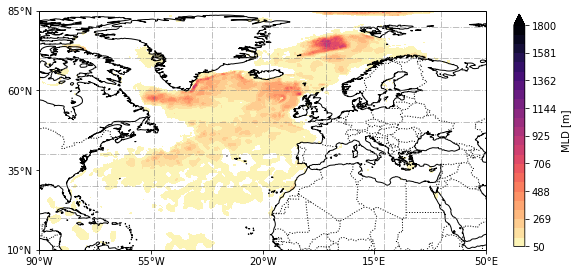

In [89]:
clevs_m = (50, 1800, 25)
Plot_2D(clim_armor.mlotst[3], 'noa', *clevs_m, cont_line=False, nlines=None)

### September

/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


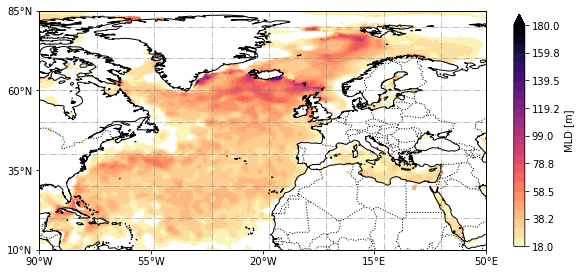

In [88]:
clevs_s = (18, 180, 25)
Plot_2D(clim_armor.mlotst[9], 'noa', *clevs_s, cont_line=False, nlines=None)

## ISAS Mixed Layer Depth

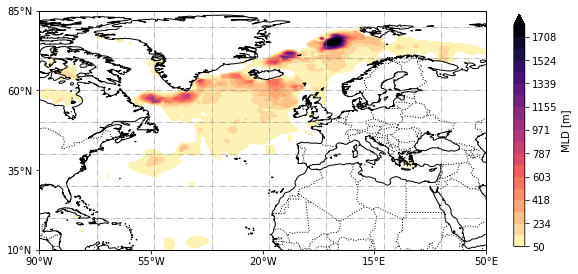

In [87]:
clevs_m = (50, 1800, 20)
Plot_2D(clim_isas.MLDP[3,0], 'noa', *clevs_m, cont_line=False, nlines=None)

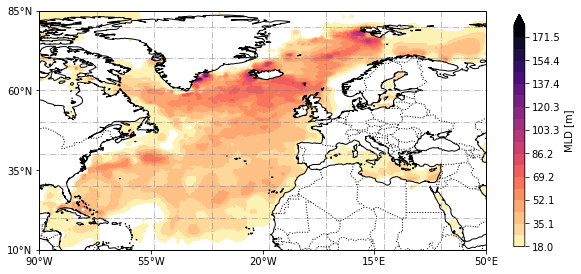

In [85]:
clevs_s = (18, 180, 20)
Plot_2D(clim_isas.MLDP[9,0], 'noa', *clevs_s, cont_line=False, nlines=None)